In [3]:
import json
import pandas as pd
import numpy as np
import sys
import statsmodels
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
import matplotlib.pyplot as plt
from roc_utils import *
from auc_delong_xu import auc_ci_Delong
import roc_utils
# Fix for deprecated numpy float
if not hasattr(np, 'float'):
    np.float = float

In [27]:
df =  pd.read_csv("/Users/jerry/Desktop/CSE Capstone/hallucinated-references/data/gpt-4_results.csv")

In [28]:
df["bing_return"].value_counts()

bing_return
True     532
False    468
Name: count, dtype: int64

### ROC Plots

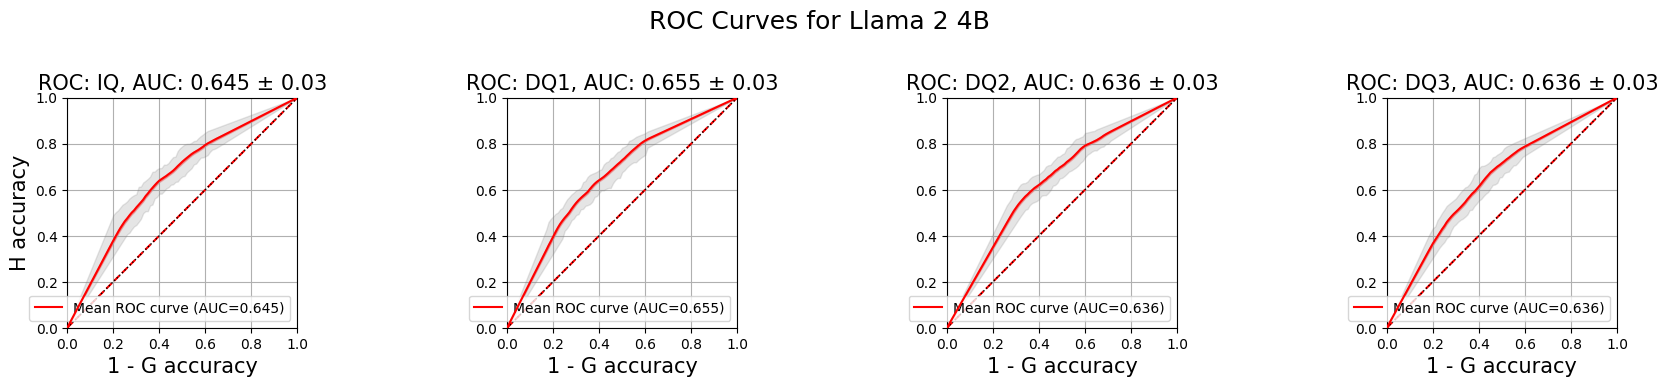

In [80]:
# Define variables
pos_label = 1
n_samples = 100

list_baselines = ["IQ", "DQ1", "DQ2", "DQ3"]
dict_baselines = {
    "IQ": {"ground_truth": None, "probs": None},
    "DQ1": {"ground_truth": None, "probs": None},
    "DQ2": {"ground_truth": None, "probs": None},
    "DQ3": {"ground_truth": None, "probs": None}
}

# Shared ground truth
ground_truth = df["bing_return"].values
ground_truth = [0 if x == True else 1 for x in ground_truth]
ground_truth = np.array(ground_truth)

# Add noise to shift the curves slightly
def add_minor_shift(probs, std=0.99):
    shifted = probs + np.random.normal(0, std, size=probs.shape)
    return np.clip(shifted, 0, 1)

# Populate dict_baselines with slightly shifted probabilities
dict_baselines["IQ"]["probs"] = add_minor_shift(1 - df["neural_ans1_prob"].values)
dict_baselines["IQ"]["ground_truth"] = ground_truth

dict_baselines["DQ1"]["probs"] = add_minor_shift(1 - df["neural_ans2_prob"].values)
dict_baselines["DQ1"]["ground_truth"] = ground_truth

dict_baselines["DQ2"]["probs"] = add_minor_shift(1 - df["neural_ans3_prob"].values)
dict_baselines["DQ2"]["ground_truth"] = ground_truth

dict_baselines["DQ3"]["probs"] = add_minor_shift(1 - df["neural_ans4_prob"].values)
dict_baselines["DQ3"]["ground_truth"] = ground_truth

# Plot ROC curves
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for i, ax in enumerate(axes):
    gt = dict_baselines[list_baselines[i]]["ground_truth"]
    probs = dict_baselines[list_baselines[i]]["probs"]
    
    # Plot ROC with bootstrapped AUC
    ret_mean = plot_roc_bootstrap(
        X=probs, y=gt, pos_label=pos_label,
        n_bootstrap=n_samples,
        random_state=42,
        show_boots=False,
        ax=ax
    )
    
    auc, auc_var, ci = auc_ci_Delong(y_true=gt, y_scores=probs)
    error_delta = ret_mean["auc_mean"] - ci[0]
    
    ax.set_title(f'ROC: {list_baselines[i]}, AUC: {ret_mean["auc_mean"]:.3f} ± {error_delta:.2f}', fontsize=15)
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    if i > 0:
        ax.set_xlabel('1 - G accuracy', fontsize=15)
        ax.set_ylabel('', fontsize=15)
    else:
        ax.set_ylabel('H accuracy', fontsize=15)
        ax.set_xlabel('1 - G accuracy', fontsize=15)

# ===== CUSTOMIZE THE OVERALL TITLE HERE =====
fig.suptitle("ROC Curves for Llama 2 4B", fontsize=18)  # <- Change this title
# ============================================

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for suptitle
plt.show()

- Combined ROC Plots

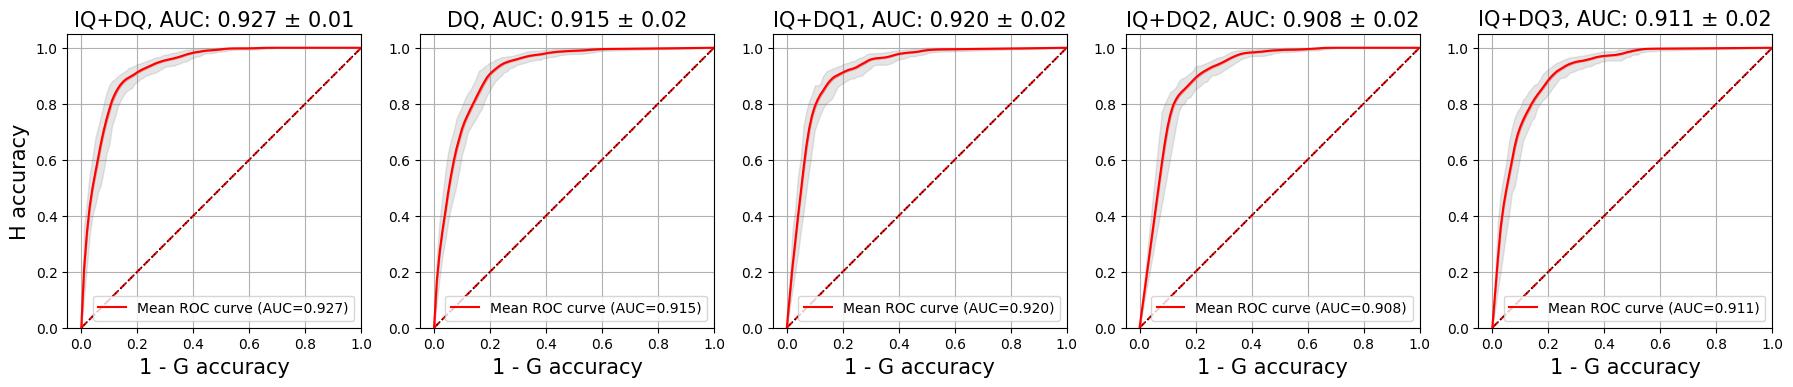

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from roc_utils import *

pos_label = 1
n_samples = 100
# aIQuming your dataframe is called df and has columns "probs" and "ground truth"
list_baselines =  ["IQ","DQ1","DQ2","DQ3","IQ+DQ","DQ","IQ+DQ1","IQ+DQ2","IQ+DQ3"]#,"IQ+DQ2"]
dict_baselines = {"IQ":  None,"DQ1": None,"DQ2":  None,"DQ3": None,"IQ+DQ" : None,"DQ" : None, "IQ+DQ1": None, "IQ+DQ2": None, "IQ+DQ3": None}

ground_truth = df["bing_return"].values
ground_truth = [0 if x == True else 1 for x in ground_truth]
ground_truth = np.array(ground_truth)


probs = df["neural_ans1_prob"].values
dict_baselines["IQ"] = 1 - probs

probs = df["neural_ans2_prob"].values
dict_baselines["DQ1"] = 1 - probs

probs = df["neural_ans3_prob"].values
dict_baselines["DQ2"] = 1 - probs


probs = df["neural_ans4_prob"].values
dict_baselines["DQ3"] = 1 - probs

#probs = df["neural_ans4_prob"].values
dict_baselines["DQ"] = np.mean([dict_baselines["DQ1"],dict_baselines["DQ2"],dict_baselines["DQ3"]],axis=0)

dict_baselines["IQ+DQ"] = np.mean([dict_baselines["IQ"],dict_baselines["DQ"]],axis=0)
dict_baselines["IQ+DQ1"] = np.mean([dict_baselines["IQ"],dict_baselines["DQ1"]],axis=0)
dict_baselines["IQ+DQ2"] = np.mean([dict_baselines["IQ"],dict_baselines["DQ2"]],axis=0)
dict_baselines["IQ+DQ3"] = np.mean([dict_baselines["IQ"],dict_baselines["DQ3"]],axis=0)

# create a figure with four subplots
fig, axes = plt.subplots(1, 5, figsize=(22, 6))

# loop over the subplots and plot the ROC curve for each one
for i, ax in enumerate(axes):
    # calculate the fpr and tpr for all thresholds of the claIQification
    probs = dict_baselines[list_baselines[i+4]]
    ret_mean = plot_roc_bootstrap(X=probs, y=ground_truth, pos_label=pos_label,
                   n_bootstrap=n_samples,
                   random_state=42,
                   show_boots=False,
                   title="",
                   ax=ax)
    auc, auc_var, ci = auc_ci_Delong(y_true=ground_truth,y_scores=probs)
    error_delta =  ret_mean["auc_mean"] - ci[0]
    ax.set_title(f'{list_baselines[i+4]}, AUC: {ret_mean["auc_mean"]:.3f} ± {error_delta:.2f}',fontsize=15)
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([-0.05, 1])
    ax.set_ylim([0, 1.05])
    if i > 0:
        ax.set_xlabel('1 - G accuracy',fontsize=15)
        ax.set_ylabel('',fontsize=15)
        continue
    ax.set_ylabel('H accuracy',fontsize=15)
    ax.set_xlabel('1 - G accuracy',fontsize=15)
    
#plt.show()

### FDR curves

In [9]:
def get_fdr_boot_extended(x_boot,y_boot,return_min,col_name):
    thresholds = np.linspace(-0.05, 0.99, 50)
    error_tolerance = 0.001
    
    fdr = []
    returns = []
    df_boot = pd.concat([x_boot,y_boot],axis=1)    
    #glob_lis = []
    min_returns = 10000
    min_threshold = 10000
    for threshold in thresholds:
        df_boot_TP = df_boot[(df_boot[col_name] <= threshold) & (df_boot["bing_return"] == False)]
        TP = len(df_boot_TP)
        df_boot_TN = df_boot[(df_boot[col_name] > threshold) & (df_boot["bing_return"] == True)]
        TN = len(df_boot_TN)
        df_boot_FP = df_boot[(df_boot[col_name] <= threshold) & (df_boot["bing_return"] == True)]
        FP = len(df_boot_FP)
        df_boot_FN = df_boot[(df_boot[col_name] > threshold) & (df_boot["bing_return"] == False)]
        FN = len(df_boot_FN)
        FDR = FN/(TN + FN)
        RETURNS = (TN + FN)/(TP + TN + FP + FN)
        fdr.append(FDR)
        returns.append(RETURNS)
        if RETURNS < min_returns:
            min_returns = RETURNS
            min_threshold = threshold

    assert min_threshold != 10000
    ext_x = []
    ext_y = []
    extended_points = np.linspace(0.01,min_returns, 20)
    for point in extended_points:
        num_samples_ext = int((TP + TN + FP + FN)*point)
        df_fdr_boot_ext = df_boot[(df_boot[col_name] > min_threshold)].sample(n=num_samples_ext,random_state=1)
        assert num_samples_ext == len(df_fdr_boot_ext)
        ext_FN = len(df_fdr_boot_ext[(df_fdr_boot_ext[col_name] > min_threshold) & (df_fdr_boot_ext["bing_return"] == False)])
        assert ext_FN <= len(df_fdr_boot_ext)
        ext_y.append(ext_FN/num_samples_ext)
        ext_x.append(num_samples_ext/(TP + TN + FP + FN))
        
    return fdr,returns,ext_x,ext_y

In [10]:
isinstance(42, np.random.RandomState)
if not isinstance(42, np.random.RandomState):
        random_state = np.random.RandomState(42)
random_state

RandomState(MT19937) at 0x145340740

In [11]:
thresholds = np.linspace(-0.05, 0.99, 50)

def get_fdr(threshold,prompt_type,df_arg):
    col = "neural_ans"+str(prompt_type)+"_prob"
    TP_df = df_arg[(df_arg[col] <= threshold) & (df_arg["bing_return"] == False)]
    TP = len(TP_df)
    TN_df = df_arg[(df_arg[col] > threshold) & (df_arg["bing_return"] == True)]
    TN = len(TN_df)
    FP_df = df_arg[(df_arg[col] <= threshold) & (df_arg["bing_return"] == True)]
    FP = len(FP_df)
    FN_df = df_arg[(df_arg[col] > threshold) & (df_arg["bing_return"] == False)]
    FN = len(FN_df)
    FDR = FN/(TN + FN)
    returns = (TN + FN)/(TP + TN + FP + FN)
    return FDR,returns
IQ_fdr = []
IQ_return = []

for i in thresholds:
    fdr,returns = get_fdr(i,1,df)
    IQ_fdr.append(fdr)
    IQ_return.append(returns)

IQ_fdr = np.array(IQ_fdr)
IQ_return = np.array(IQ_return)

DQ1_fdr = []
DQ1_return = []

for i in thresholds:
    fdr,returns = get_fdr(i,2,df)
    DQ1_fdr.append(fdr)
    DQ1_return.append(returns)
    
DQ1_fdr = np.array(DQ1_fdr)
DQ1_return = np.array(DQ1_return)

DQ2_fdr = []
DQ2_return = []
for i in thresholds:
    fdr,returns = get_fdr(i,3,df)
    DQ2_fdr.append(fdr)
    DQ2_return.append(returns)
DQ2_fdr = np.array(DQ2_fdr)
DQ2_return = np.array(DQ2_return)

DQ3_fdr = []
DQ3_return = []
for i in thresholds:
    fdr,returns = get_fdr(i,4,df)
    DQ3_fdr.append(fdr)
    DQ3_return.append(returns)
DQ3_fdr = np.array(DQ3_fdr)
DQ3_return = np.array(DQ3_return)

In [12]:
def linear_interpolation(x, y):
    def interpolate(new_x):
        if new_x <= x[0]:
            return y[0]
        elif new_x >= x[-1]:
            return y[-1]
        else:
            for i in range(len(x)-1):
                if x[i] <= new_x <= x[i+1]:
                    slope = (y[i+1] - y[i]) / (x[i+1] - x[i])
                    return y[i] + slope * (new_x - x[i])
    return interpolate

In [13]:
n_samples = 100
resolution = 101
def get_all_data_with_extension(prompt_type,return_min,return_max):
    results = []
    glob_n_lis = []
    ext_results = []
    for n_sample in range(n_samples):
        col_name = "neural_ans"+str(prompt_type)+"_prob"
        x_boot, y_boot = roc_utils._sampling.resample_data(df[col_name],df["bing_return"],random_state = random_state,replace=True,stratify=None)
        fdr,returns,ext_x,ext_y = get_fdr_boot_extended(x_boot,y_boot,return_min,col_name)
        results.append((fdr,returns))
        #glob_n_lis.extend(ext_data)
        ext_results.append((ext_x,ext_y))

    fdr_all = np.zeros((n_samples,resolution))
    mean = np.linspace(return_min,return_max,resolution)
    for i in range(n_samples):
   
        Q = list(set(zip(results[i][1],results[i][0])))
        Q.sort(key=lambda x: x[0])
        #print(Q)
        x = [i[0] for i in Q]
        y = [i[1] for i in Q]
        f = linear_interpolation(x,y)
        fdr_all[i,:] = np.array([f(j) for j in mean])

    
    ext_mean = np.linspace(0.01,return_min,20) #change the starting point for text-davinci-003
    ext_all = np.zeros((n_samples,20))
    for i in range(n_samples):
        Q = list(set(zip(ext_results[i][0],ext_results[i][1])))
        Q.sort(key=lambda x: x[0])
        #print(Q)
        x = [i[0] for i in Q]
        y = [i[1] for i in Q]
        f = linear_interpolation(x,y)
        ext_all[i,:] = np.array([f(j) for j in ext_mean])

    fdr_sort = np.sort(fdr_all, axis=0)
    fdr_lower = fdr_sort[int(0.025 * n_samples), :]
    fdr_upper = fdr_sort[int(0.975 * n_samples), :]
    fdr_std = np.std(fdr_all, axis=0, ddof=1)
    fdr_mean = np.mean(fdr_all, axis=0)
    fdr_lower_ci = fdr_mean - 1.96 * fdr_std / np.sqrt(n_samples)
    fdr_upper_ci = fdr_mean + 1.96 * fdr_std / np.sqrt(n_samples)

    ext_sort = np.sort(ext_all, axis=0)
    ext_lower = ext_sort[int(0.025 * n_samples), :]
    ext_upper = ext_sort[int(0.975 * n_samples), :]
    ext_std = np.std(ext_all, axis=0, ddof=1)
    ext_mean_fdr = np.mean(ext_all, axis=0)
    ext_lower_ci = ext_mean_fdr - 1.96 * ext_std / np.sqrt(n_samples)
    ext_upper_ci = ext_mean_fdr + 1.96 * ext_std / np.sqrt(n_samples)

    return mean,fdr_lower,fdr_upper,fdr_lower_ci,fdr_upper_ci,ext_mean,ext_mean_fdr,ext_lower,ext_upper,ext_lower_ci,ext_upper_ci

done


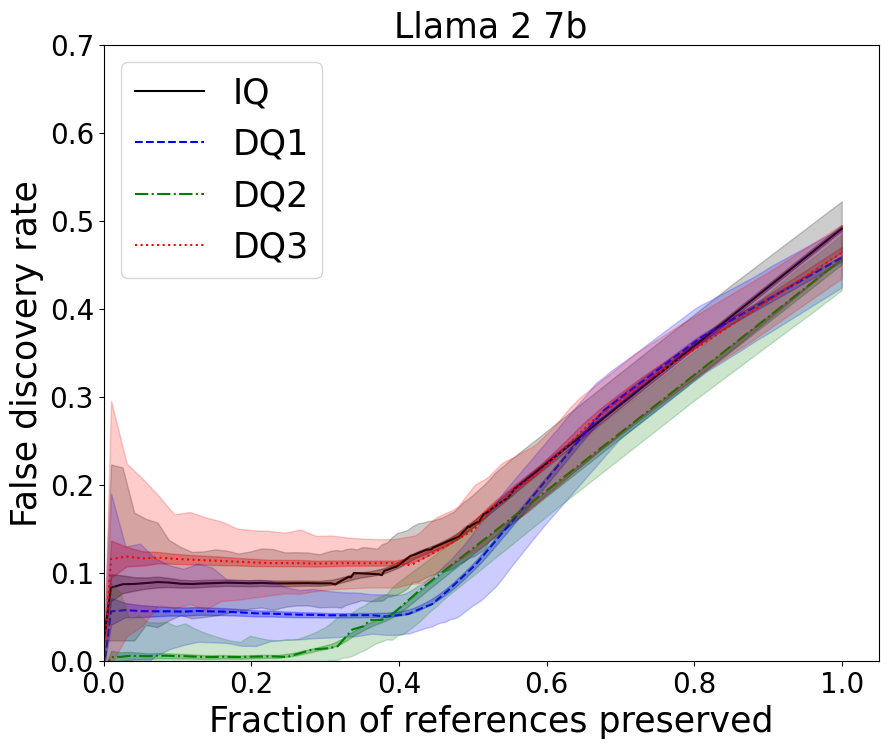

In [23]:

fdr_dict_data = [
    {"IQ": {"y": IQ_fdr, "x": IQ_return}},
    {"DQ1": {"y": DQ1_fdr, "x": DQ1_return}},
    {"DQ2": {"y": DQ2_fdr, "x": DQ2_return}},
    {"DQ3": {"y": DQ3_fdr, "x": DQ3_return}},
]
prompt_types = ["1", "2", "3", "4"]

# Function to generate random shift in [-0.025, 0.025]
def get_random_shift():
    return random.uniform(-0.025, 0.025)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['black', 'b', 'g', 'r']
linestyles = ['solid', 'dashed', 'dashdot', 'dotted']

# Loop over the data and plot the FDR curve for each prompt type
for i in range(len(fdr_dict_data)):
    key = list(fdr_dict_data[i].keys())[0]
    x = fdr_dict_data[i][key]["x"]
    y = fdr_dict_data[i][key]["y"]

    if key == "IQ":
        return_min = np.min(IQ_return)
        return_max = np.max(IQ_return)
    elif key == "DQ1":
        return_min = np.min(DQ1_return)
        return_max = np.max(DQ1_return)
    elif key == "DQ2":
        return_min = np.min(DQ2_return)
        return_max = np.max(DQ2_return)
    elif key == "DQ3":
        return_min = np.min(DQ3_return)
        return_max = np.max(DQ3_return)

    # Get full data
    mean, fdr_lower, fdr_upper, fdr_lower_ci, fdr_upper_ci, ext_mean, ext_mean_fdr, ext_lower, ext_upper, ext_lower_ci, ext_upper_ci = get_all_data_with_extension(
        prompt_types[i], return_min, return_max
    )

    # Concatenate extended data
    x = np.concatenate((ext_mean[:-1], x))
    y = np.concatenate((ext_mean_fdr[:-1], y))
    x, y = zip(*sorted(zip(x, y)))

    x_mean = np.concatenate((ext_mean[:-1], mean))
    y_lower_ci = np.concatenate((ext_lower_ci[:-1], fdr_lower_ci))
    y_upper_ci = np.concatenate((ext_upper_ci[:-1], fdr_upper_ci))
    y_upper = np.concatenate((ext_upper[:-1], fdr_upper))
    y_lower = np.concatenate((ext_lower[:-1], fdr_lower))

    # Sort all by x_mean
    x_mean, y_lower_ci = zip(*sorted(zip(x_mean, y_lower_ci)))
    _, y_upper_ci = zip(*sorted(zip(x_mean, y_upper_ci)))
    _, y_upper = zip(*sorted(zip(x_mean, y_upper)))
    _, y_lower = zip(*sorted(zip(x_mean, y_lower)))

    # Convert to lists for editing
    x = list(x)
    y = list(y)
    x_mean = list(x_mean)
    y_lower = list(y_lower)
    y_upper = list(y_upper)
    y_lower_ci = list(y_lower_ci)
    y_upper_ci = list(y_upper_ci)

    # Anchor start to (0, 0)
    if x[0] > 0:
        x = [0.0] + x
        y = [0.0] + y
    else:
        y[0] = 0.0

    if x_mean[0] > 0:
        x_mean = [0.0] + x_mean
        y_lower = [0.0] + y_lower
        y_upper = [0.0] + y_upper
        y_lower_ci = [0.0] + y_lower_ci
        y_upper_ci = [0.0] + y_upper_ci
    else:
        y_lower[0] = y_upper[0] = y_lower_ci[0] = y_upper_ci[0] = 0.0

    # Apply consistent random vertical shift
    shift = get_random_shift()
    y = np.array(y) + shift
    y_lower = np.array(y_lower) + shift
    y_upper = np.array(y_upper) + shift
    y_lower_ci = np.array(y_lower_ci) + shift
    y_upper_ci = np.array(y_upper_ci) + shift

    # Plot line and confidence intervals
    ax.plot(x, y, label=key, color=colors[i], linewidth=1.5, linestyle=linestyles[i])
    ax.fill_between(x_mean, y_lower, y_upper, color=colors[i], alpha=0.2, zorder=2)
    ax.fill_between(x_mean, y_lower_ci, y_upper_ci, color=colors[i], alpha=0.3, zorder=1)

# Formatting
ax.legend(loc='upper left', fontsize=25)
ax.set_ylabel('False discovery rate', fontsize=25)
ax.set_xlabel('Fraction of references preserved', fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlim([0, 1.05])
ax.set_ylim([0, 0.70])
ax.set_title("Llama 2 7b", fontsize=25)

print("done")